<a href="https://colab.research.google.com/github/JanePer/AI---PORTFOLIO/blob/main/Task11_(Lite)_GAN_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D1%8B%D0%B5_%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries 
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
%matplotlib inline


from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.layers import Dense, Input, Reshape, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D, concatenate, Embedding, multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img_height=28
img_width=28
img_channels=1
img_pix_val=255
img_shape=(img_height,img_width,img_channels)
latent_dim=100
optimizer=Adam(0.0002,0.5)

In [ ]:
def create_generator():
  generator=Sequential()
  generator.add(Dense(256,input_dim=latent_dim))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(512))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(1024))
  generator.add(LeakyReLU(alpha=0.2))
  generator.add(BatchNormalization(momentum=0.8))
  generator.add(Dense(np.prod(img_shape), activation='tanh'))
  generator.add(Reshape(img_shape))

  noise=Input(shape=(latent_dim,))
  img=generator(noise)

  generator=Model(noise, img)
  return generator

In [ ]:
def create_discriminator():
  discriminator=Sequential()
  discriminator.add(Flatten(input_shape=img_shape))
  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dense(1, activation='sigmoid'))

  img=Input(shape=img_shape)
  validity=discriminator(img)

  discriminator=Model(img, validity)

  discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  discriminator.trainable=False # freeze discriminator's weights
  return discriminator

In [ ]:
(x_train,_),(_,_)=mnist.load_data()

x_train=x_train/(img_pix_val/2) - 1 #transform to range (-1,1) - activation 'tanh'
x_train=x_train.reshape(len(x_train), img_height,img_width,img_channels)
print(x_train.shape)

(60000, 28, 28, 1)


In [ ]:
def sample_images(epoch, gen): # Функция печати изображений
  r, c = 5, 5 # Параметры вывода (количество строк (r) и количество столбцов (c))
  noise = np.random.normal(0, 1, (r * c, latent_dim)) # Создаем вектор размерностью (r*c,latent_dim (25,100)) из нормально распределенных значений
  gen_imgs = gen.predict(noise) # Предиктим картинку с помощью входной переменной gen
  
  #gen_imgs = 0.5 * gen_imgs + 0.5 # Трансформируем значения в диапазон от 0 до 1

  fig, axs = plt.subplots(r, c) # Создаем окно вывода r на c (5 на 5) ячеек
  cnt = 0 # Порядковый номер картинки
  for i in range(r): 
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray') # Записываем в axs[i,j] сгенерироввнное изображение из gen_img с индексом cnt
          axs[i,j].axis('off') # Отключаем печать названия осей
          cnt += 1 # Увеличиваем индекс изображения
  plt.show() # Рисуем сгенерированные изображения
  #fig.savefig("images/%d.png" % epoch) # Сохраняем изображения в папке images
  plt.close() # Завершаем работу с plt

In [ ]:
def train(generator, discriminator, iters=10000, batch_size=128):
  valid=np.ones((batch_size,1)) #array with values '1'
  fake=np.zeros((batch_size,1)) #array with values '0'

  z=Input(shape=(latent_dim,))
  img=generator(z)
  validity=discriminator(img)

  combined=Model(z, validity)
  combined.compile(loss='binary_crossentropy', optimizer=optimizer)

  sample_interval=200

  dis_losses_list=[]
  gen_losses_list=[]
  dis_accuracy_list=[]

  for iter in range(iters):
      index=np.random.randint(0,x_train.shape[0], batch_size)
      imgs=x_train[index]

      noise=np.random.normal(0,1,(batch_size,latent_dim))
      gen_imgs=generator.predict(noise)

      # Train the discriminator
      dis_losses_real=discriminator.train_on_batch(imgs,valid)
      dis_losses_fake=discriminator.train_on_batch(gen_imgs,fake)
      dis_losses=0.5 * np.add(dis_losses_real, dis_losses_fake)

      # Train the generator
      gen_losses=combined.train_on_batch(noise,valid)
      print("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (iter, dis_losses[0], 100*dis_losses[1], gen_losses))

      dis_losses_list.append(dis_losses[0])
      gen_losses_list.append(gen_losses)
      dis_accuracy_list.append(100*dis_losses[1])

      if ((iter % sample_interval==0) | (iter==iters-1)):
        clear_output()
        sample_images(iter,generator)
  plt.plot(dis_losses_list, label="Discriminator Loss")
  plt.plot(gen_losses_list, label="Generator Loss")
  plt.legend()
  plt.show()
  plt.plot(dis_accuracy_list, label="Discriminator Accuracy")
  plt.legend()
  plt.show()

#Latent_dim = 100

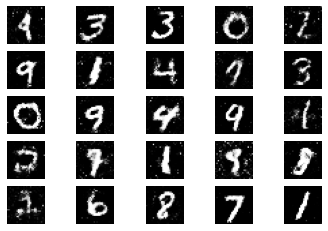

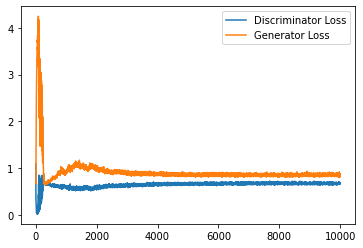

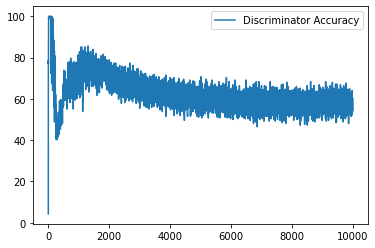

In [ ]:
generator=create_generator()
discriminator=create_discriminator()
train(generator, discriminator)

#Latent_dim = 10


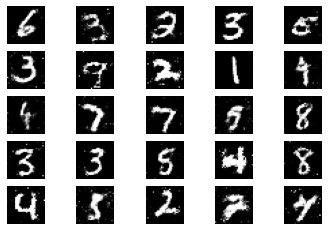

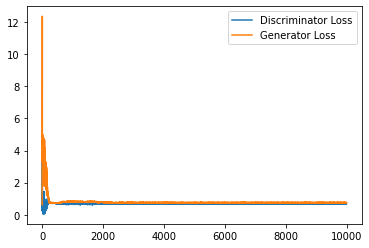

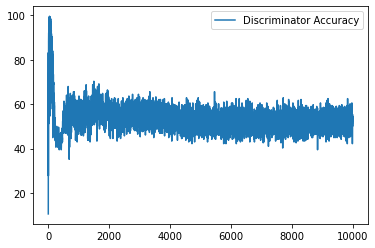

In [ ]:
latent_dim=10
generator=create_generator()
discriminator=create_discriminator()
train(generator, discriminator)

#Latent_dim = 1000

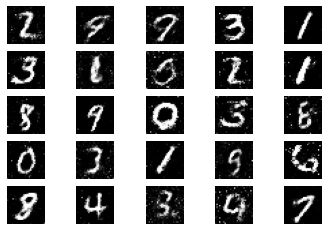

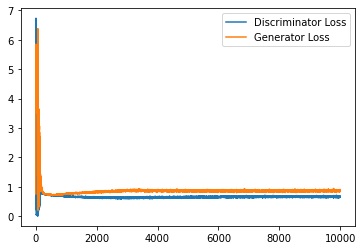

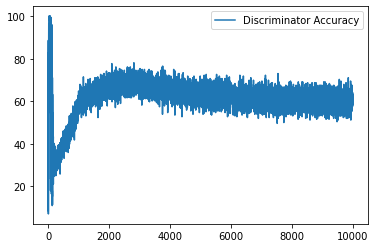

In [ ]:
latent_dim=1000
generator=create_generator()
discriminator=create_discriminator()
train(generator, discriminator)

#Convolutional Generator

In [ ]:
def create_conv_generator():
  conv_generator=Sequential()
  conv_generator.add(Dense(img_height*img_width,input_dim=latent_dim))
  conv_generator.add(LeakyReLU(alpha=0.2))
  conv_generator.add(BatchNormalization(momentum=0.8))
  conv_generator.add(Reshape(img_shape))
  conv_generator.add(Conv2D(128, (2,2), padding="same"))
  conv_generator.add(LeakyReLU(alpha=0.2))
  conv_generator.add(BatchNormalization(momentum=0.8))
  conv_generator.add(Conv2D(64, (2,2), padding="same"))
  conv_generator.add(LeakyReLU(alpha=0.2))
  conv_generator.add(BatchNormalization(momentum=0.8))
  conv_generator.add(Conv2D(32, (2,2), padding="same"))
  conv_generator.add(LeakyReLU(alpha=0.2))
  conv_generator.add(BatchNormalization(momentum=0.8))
  conv_generator.add(Conv2D(4, (2,2), padding="same", activation='tanh'))
  conv_generator.add(MaxPooling2D(pool_size=(2,2)))
  conv_generator.add(Flatten())
  conv_generator.add(Reshape(img_shape))

  noise=Input(shape=(latent_dim,))
  img=conv_generator(noise)

  conv_generator=Model(noise, img)
  return conv_generator

In [ ]:
conv_gen=create_conv_generator()
conv_gen.summary()

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
sequential_28 (Sequential)   (None, 28, 28, 1)         125428    
Total params: 125,428
Trainable params: 123,412
Non-trainable params: 2,016
_________________________________________________________________


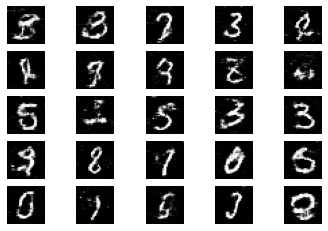

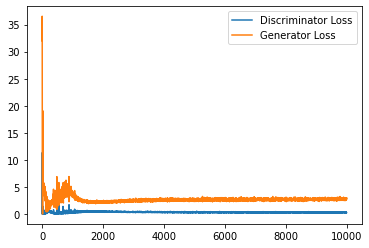

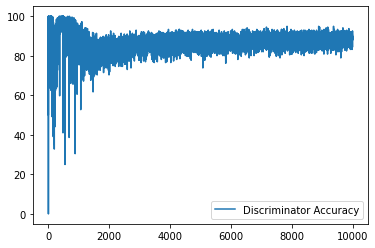

In [ ]:
latent_dim=100
generator=create_conv_generator()
discriminator=create_discriminator()
train(generator, discriminator)

#Different batch sizes for Generator and Discriminator

In [ ]:
def train(generator, discriminator, iters=10000, dis_batch_size=128, gen_batch_size=256):
  valid=np.ones((gen_batch_size,1)) #array with values '1'
  fake=np.zeros((gen_batch_size,1)) #array with values '0'

  z=Input(shape=(latent_dim,))
  img=generator(z)
  validity=discriminator(img)

  combined=Model(z, validity)
  combined.compile(loss='binary_crossentropy', optimizer=optimizer)

  sample_interval=200

  dis_losses_list=[]
  gen_losses_list=[]
  dis_accuracy_list=[]

  for iter in range(iters):
      index=np.random.randint(0,x_train.shape[0], dis_batch_size)
      imgs=x_train[index]

      noise=np.random.normal(0,1,(gen_batch_size,latent_dim))
      gen_imgs=generator.predict(noise)

      # Train the discriminator
      dis_losses_real=discriminator.train_on_batch(imgs,valid[:dis_batch_size])
      dis_losses_fake=discriminator.train_on_batch(gen_imgs[:dis_batch_size],fake[:dis_batch_size])
      dis_losses=0.5 * np.add(dis_losses_real, dis_losses_fake)

      # Train the generator
      gen_losses=combined.train_on_batch(noise,valid)
      print("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (iter, dis_losses[0], 100*dis_losses[1], gen_losses))

      dis_losses_list.append(dis_losses[0])
      gen_losses_list.append(gen_losses)
      dis_accuracy_list.append(100*dis_losses[1])

      if ((iter % sample_interval==0) | (iter==iters-1)):
        clear_output()
        sample_images(iter,generator)
  plt.plot(dis_losses_list, label="Discriminator Loss")
  plt.plot(gen_losses_list, label="Generator Loss")
  plt.legend()
  plt.show()
  plt.plot(dis_accuracy_list, label="Discriminator Accuracy")
  plt.legend()
  plt.show()

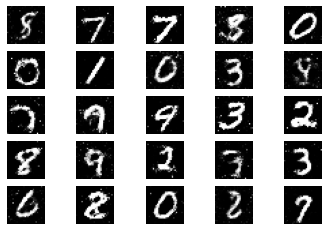

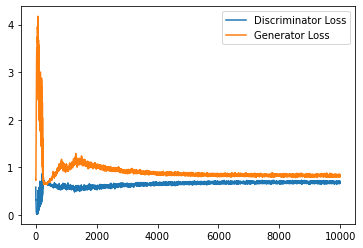

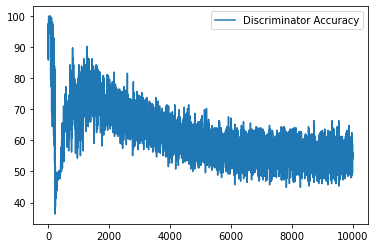

In [ ]:
latent_dim=100
generator=create_generator()
discriminator=create_discriminator()
train(generator, discriminator)

1. If to compare different latent_dim amounts 100 and 1000 shows better results than 10, so the larger latent_dim can improve model's accuracy
2. If to compare Dense and Conv Generator - unexpectedly Dense has more clear results than Conv.
3. If to compare GAN with the same batch sizes for generator and discriminator with GAN that has different batch sizes for generator and discriminator seems they show similar results based on image review but the second has less accuracy.